# Simulations

In this notebook we detail how simulations to generate measured events that can be analysed with GammaBayes. 

There are essentially three steps to these simulations.

1. Setup: Create the relevant priors and likelihoods that describe your astrophysical sources and instrumental noise (there is a more detailed explanation on these in the relevant notebooks)

2. True Value Sampling: Sample the priors to obtain the "true values" that correspond to what a perfect instrument would see

3. Measured Value Sampling: With the true value samples, sample the likelihoods to add noise to the measurements to obtain events similar to what the CTA would see

## 1. Setup

Within the docs folder containing this file is a file named `example_run_script.yaml` which works as a configuration file. We generally advise the use of these files although the format is mostly not enforced within `GammaBayes`.

In [1]:
import sys, numpy as np, random
from gammabayes.utils.config_utils import read_config_file
random.seed(1)

config_inputs = read_config_file('example_run_script.yaml')

nsig                = int(round(config_inputs['signal_fraction']*config_inputs['Nevents']))
nbkg                = int(round((1-config_inputs['signal_fraction'])*config_inputs['Nevents']))

file path: example_run_script.yaml


/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Axes

We will first create the our priors. For this we will need to set up the axes over which the true values can be made in `Energy`, `galactic longitude` and `galactic latitude`.

For now we will let there be 100 bins per decade in energy from 0.1 TeV to 100 TeV. The bounds in all cases mostly being defined by where the Instruments Response Functions (our likelihoods) are well-defined.

Our Galactic Latitude will have the bounds of -3.5 to 3.5 (our 356.5 to 3.5 if you prefer, but the math is easier with symmetry) with a resolution of 0.4. This is not what one would want to use in a full-blown simulation, but any increase in particularly the spatial axes can significantly increase computation time for later stages of analysis.

Our Galactic Longitude will then have bounds of -3.0 to 3.0 also with a resolution of 0.4. This is mostly to show you don't need a completely symmetry observation window here and can use whatever you wish.

These axes are named `log10_eaxis_true`, `longitude_axis_true` and `latitude_axis_true` respectively.

In [2]:
from gammabayes.utils.config_utils import create_recon_axes_from_config, create_true_axes_from_config


energy_axis_true, longitude_axis_true, latitude_axis_true = create_true_axes_from_config(config_inputs)
true_mass = config_inputs['mass']

0.1 100 150 0.2 -3.1 3.1 -3.0 3.0


Let's have a quick look at the shapes, so that it is easier to keep track of each axes for the oncoming steps.

In [3]:
print(energy_axis_true.shape, longitude_axis_true.shape, latitude_axis_true.shape)

(451,) (32,) (31,)


We will also need the axes of the values that actual CTA measurements can take.

In [4]:
energy_axis, longitude_axis, latitude_axis = create_recon_axes_from_config(config_inputs)

0.1 100 50 0.4 -3.1 3.1 -3.0 3.0


### Creating priors

And now we can get start on creating the priors that we will need. We will import the `discrete_prior` class from GammaBayes.

In [5]:
from gammabayes.priors import discrete_logprior


To create the relevant dark matter spectra we will use the `SS_DM_dist` class from GammaBayes. Initial creation of the function should take less than 10 seconds.

In [6]:
from gammabayes.dark_matter import SS_DM_dist

SS_DM_dist_instance= SS_DM_dist(longitude_axis_true, latitude_axis_true, density_profile=config_inputs['dmdensity_profile'])
logDMpriorfunc = SS_DM_dist_instance.func_setup()

Now let's initiate the prior class for our signal and have a look at what it contains.

In [7]:
DM_prior = discrete_logprior(logfunction=logDMpriorfunc, name='Scalar Singlet Dark Matter Prior',
                               axes=(energy_axis_true, longitude_axis_true, latitude_axis_true,), 
                               axes_names=['energy [TeV]', 'lon', 'lat'],
                               default_hyperparameter_values=(true_mass,), 
                               hyperparameter_names=['mass'],)
DM_prior

discrete log prior class
----------------------------
name = Scalar Singlet Dark Matter Prior
logfunction type is <function SS_DM_dist.func_setup.<locals>.DM_signal_dist at 0x1555a5940>
input units of None
over axes ['energy [TeV]', 'lon', 'lat']
with hyperparameter(s) ['mass']

So we have a signal, we next need a background. This is more thoroughly detailed in the `prior_class` jupyter notebook.

In [8]:
from gammabayes.priors import log_bkg_CCR_dist
from gammabayes.priors.astro_sources import construct_fermi_gaggero_matrix, construct_hess_source_map
from scipy import special, interpolate

nuisancemesh = np.meshgrid(energy_axis_true, longitude_axis_true, latitude_axis_true, indexing='ij')

from gammabayes.priors.astro_sources import construct_hess_source_map, construct_fermi_gaggero_matrix


astrophysicalbackground = construct_hess_source_map(energy_axis_true, longitude_axis_true, latitude_axis_true)+construct_fermi_gaggero_matrix(energy_axis_true, longitude_axis_true, latitude_axis_true)

log_misidentification_rate = np.squeeze(log_bkg_CCR_dist(*nuisancemesh))

unnormed_logbkgpriorvalues = np.logaddexp(log_misidentification_rate,np.log(astrophysicalbackground))


logbkgfunc_tuple_input = interpolate.RegularGridInterpolator((energy_axis_true, longitude_axis_true, latitude_axis_true,), np.exp(unnormed_logbkgpriorvalues))
logbkgfunc = lambda energy, longitude, latitude: np.log(logbkgfunc_tuple_input((energy, longitude, latitude)))


bkg_prior = discrete_logprior(logfunction=logbkgfunc, name='Background Prior',
                               axes=(energy_axis_true, longitude_axis_true, latitude_axis_true,), 
                               axes_names=['energy', 'lon', 'lat'],)

bkg_prior

/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammapy/modeling/models/spatial.py:554: RuntimeWarning: invalid value encountered in multiply
  return u.Quantity(norm * np.exp(exponent).value, "sr-1", copy=False)


discrete log prior class
----------------------------
name = Background Prior
logfunction type is <function <lambda> at 0x155735940>
input units of None
over axes ['energy', 'lon', 'lat']
with hyperparameter(s) ['None']

### Creating Likelihoods

Within the `gammabayes.likelihoods.irfs` there is a class called `irf_loglikelihood` which is mentioned at the end of the `likelihood_classes` tutorial. This class allows very easy use of standard IRFs produced by the CTA.

In [9]:
from gammabayes.likelihoods.irfs import irf_loglikelihood

We then instantiate the IRF log-likelihood like so.

In [10]:
irf_like = irf_loglikelihood(zenith=20, hemisphere='S', prod_vers=5,
                               axes=(energy_axis, longitude_axis, latitude_axis), axes_names='E recon',
                               name='IRF loglikelihood',
                               dependent_axes=(energy_axis_true, longitude_axis_true, latitude_axis_true,),
                               dependent_axes_names = ['E true', 'lon', 'lat'])
irf_like


Path to irf fits file: /Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/utils/../package_data/irf_fits_files/prod5/CTA-Performance-prod5-v0.1-South-20deg.FITS/Prod5-South-20deg-AverageAz-14MSTs37SSTs.180000s-v0.1.fits.gz

Number of input dimensions 3


discrete log likelihood class
---------------------------------
name = IRF loglikelihood
logfunction type is <bound method irf_extractor.single_loglikelihood of <gammabayes.likelihoods.irfs.irf_extractor_class.irf_extractor object at 0x15572bec0>>
input units of ['None']
over axes E recon
with dependent axes ['E true', 'lon', 'lat']

The `Number of input dimesions` parameter describes the dimensionality of the axes that the likelihood is normalised with respect to. Here the IRF log-likelihood is with respect to the 1 energy dimension and 2 angular/sky position dimensions so the number of total input dimensions is 3.

## 2. True Value Sampling

Now that we have completed all the setup we can use the in-built methods and attributes of the classes we have set up to do the rest of the heavy lifting. 

We will set the fraction of signal events to total events to 0.6 (for illustrative purposes) and the total number of events to be measured to 5000. This means there will be 3000 signal events and 2000 background events.

In [11]:
signal_fraction = config_inputs['signal_fraction']
total_events = config_inputs['totalevents']

To sample the priors we can then use the `sample` method with the number of samples we want. The output will be a tuple of the values in each of the dependent axes of the priors.

In [12]:
sig_energy_vals,siglonvals,siglatvals  = DM_prior.sample(nsig)

bkg_energy_vals,bkglonvals,bkglatvals  = bkg_prior.sample(nbkg)

Let's plot the functions for these priors (with the proper jacobians) along the energy axis and compare them to the samples that we generated.

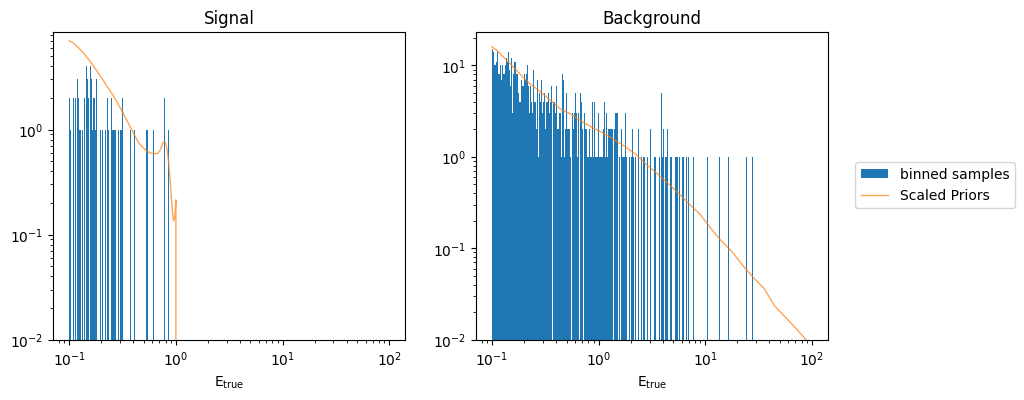

In [13]:
import matplotlib.pyplot as plt
from gammabayes.utils import bin_centres_to_edges
from gammabayes.utils.event_axes import makelogjacob
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title('Signal')
logjacob_true = np.meshgrid(makelogjacob(energy_axis_true), longitude_axis_true, latitude_axis_true, indexing='ij')[0]
signal_plot_vals = np.sum(np.exp(DM_prior.logfunction(*[mesh.flatten() for mesh in np.meshgrid(energy_axis_true, longitude_axis_true, latitude_axis_true, true_mass, indexing='ij')], ).reshape(logjacob_true.shape)+logjacob_true), axis=(1,2))
sig_true_histvals, sig_true_hist_bins, _ = plt.hist(sig_energy_vals, bins=bin_centres_to_edges(energy_axis_true), label='binned samples')

plt.plot(energy_axis_true, signal_plot_vals/np.max(signal_plot_vals)*np.max(sig_true_histvals), lw=1, label="Scaled Prior", alpha=0.7)

plt.loglog()
plt.ylim([0.01,None])

plt.xlabel(r'E$_{\rm{true}}$')

plt.subplot(122)
plt.title('Background')


background_plot_vals = np.sum(np.exp(bkg_prior.logfunction(*np.meshgrid(energy_axis_true, longitude_axis_true, latitude_axis_true, indexing='ij'),)+logjacob_true), 
                              axis=(1,2))
background_true_histvals, background_true_hist_bins, _ = plt.hist(bkg_energy_vals, bins=bin_centres_to_edges(energy_axis_true), label='binned samples')


plt.plot(energy_axis_true, background_plot_vals/np.max(background_plot_vals)*np.max(background_true_histvals), lw=1, label="Scaled Priors", alpha=0.7)

plt.loglog()
plt.ylim([0.01,None])
plt.legend(bbox_to_anchor=(1.55,0.6))
plt.xlabel(r'E$_{\rm{true}}$')
plt.show()


With a change in the overall normalisation for the prior functions, the histograms should roughly match the plotted priorvalues.

And then we'll just have a quick look at the sky position sampling.

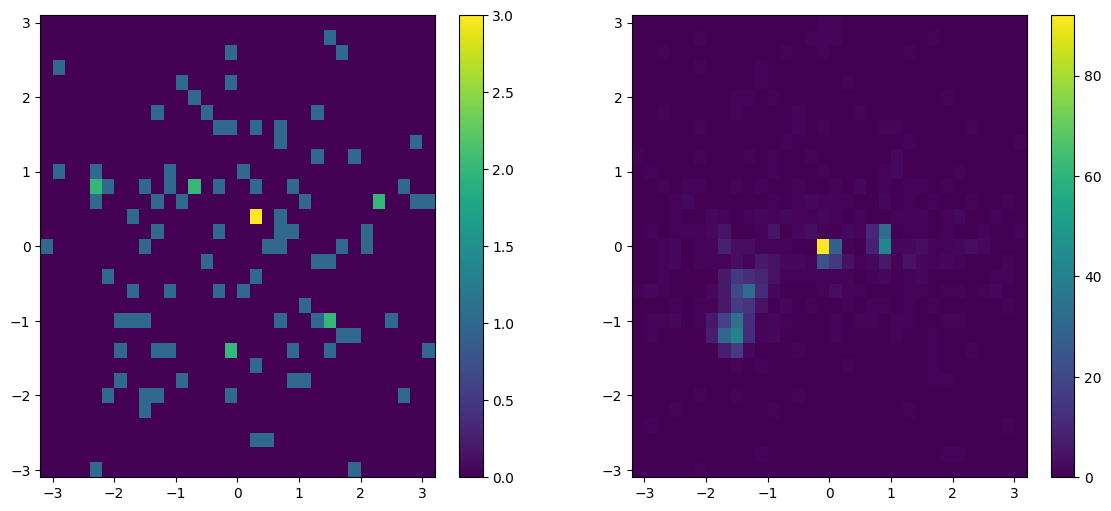

In [14]:
from matplotlib.colors import LogNorm


plt.figure(figsize=(14,6))
plt.subplot(121)
plt.hist2d(siglonvals,siglatvals, 
           bins=(bin_centres_to_edges(longitude_axis_true), bin_centres_to_edges(latitude_axis_true)))#, norm=LogNorm(vmin=1))
plt.colorbar()

plt.subplot(122)
plt.hist2d(bkglonvals,bkglatvals, 
           bins=(bin_centres_to_edges(longitude_axis_true), bin_centres_to_edges(latitude_axis_true)))
plt.colorbar()

plt.show()

## 3. Measured Value Sampling

Now that we have our "true values" we can create our "measured" or "reconstructed" values by sampling the likelihoods given the true values.

In [15]:
from tqdm.autonotebook import tqdm as notebook_tqdm

signal_energy_measured, signal_lon_measured, signal_lat_measured = np.asarray([np.squeeze(irf_like.sample((energy_val,*coord,), numsamples=1)) for energy_val,coord  in notebook_tqdm(zip(sig_energy_vals, np.array([siglonvals, siglatvals]).T), total=nsig)]).T

bkg_energy_measured, bkg_lon_measured, bkg_lat_measured = np.asarray([np.squeeze(irf_like.sample((energy_val,*coord,), numsamples=1)) for energy_val,coord  in notebook_tqdm(zip(bkg_energy_vals, np.array([bkglonvals, bkglatvals]).T), total=nbkg)]).T


100%|██████████| 900/900 [00:27<00:00, 32.22it/s]


Now let's have a thorough look at our outputs.

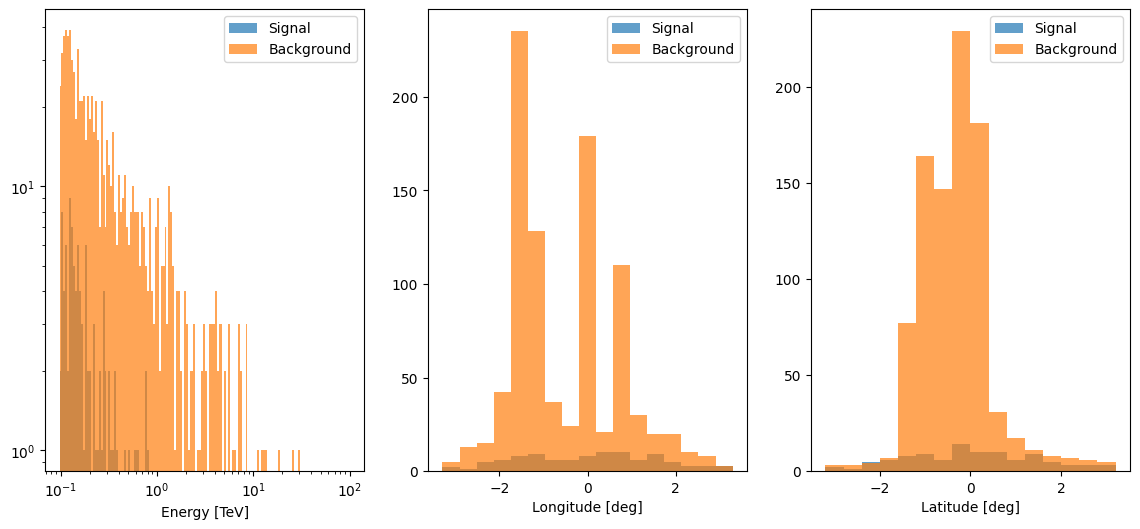

In [16]:
alpha=0.7
plt.figure(figsize=(14,6))
plt.subplot(131)
plt.hist(signal_energy_measured, bins=bin_centres_to_edges(energy_axis), color='tab:blue', alpha=alpha, label='Signal')
plt.hist(bkg_energy_measured,   bins=bin_centres_to_edges(energy_axis), color='tab:orange', alpha=alpha, label='Background')
plt.loglog()
plt.xlabel('Energy [TeV]')

plt.legend()

plt.subplot(132)

plt.hist(signal_lon_measured, bins=bin_centres_to_edges(longitude_axis), color='tab:blue', alpha=alpha, label='Signal')
plt.hist(bkg_lon_measured, bins=bin_centres_to_edges(longitude_axis), color='tab:orange', alpha=alpha, label='Background')
plt.xlabel('Longitude [deg]')

plt.legend()



plt.subplot(133)

plt.hist(signal_lon_measured, bins= bin_centres_to_edges(latitude_axis), color='tab:blue', alpha=alpha, label='Signal')
plt.hist(bkg_lat_measured, bins= bin_centres_to_edges(latitude_axis), color='tab:orange', alpha=alpha, label='Background')
plt.legend()
plt.xlabel('Latitude [deg]')


plt.show()

The next recommended notebook to follow is called `hyperparameter_inference.ipynb` which analyses the simulations found here to reconstruct the $log_{10}$ mass value and fraction of events that come from the signal.

In [17]:
import os
os.makedirs('tutorial_data', exist_ok=True)


np.save(f'tutorial_data/recon_bkg_samples.npy', np.array([bkg_energy_measured, bkg_lon_measured, bkg_lat_measured]))
np.save(f'tutorial_data/recon_sig_samples.npy', np.array([signal_energy_measured, signal_lon_measured, signal_lat_measured]))